# Varying Height

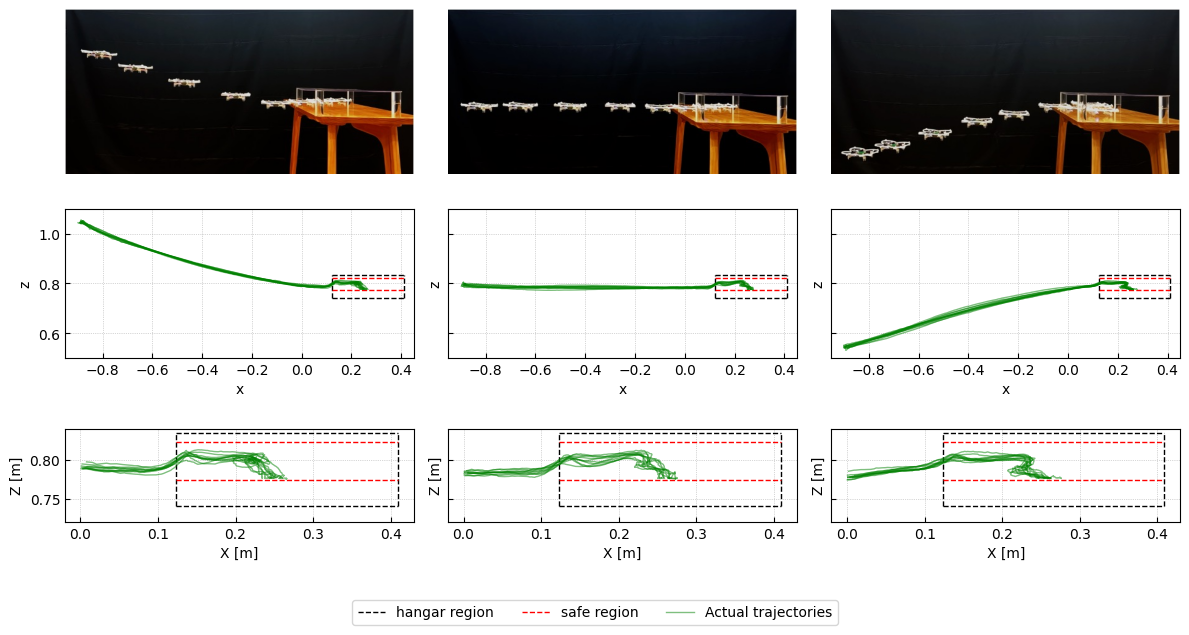

Plot saved to pdf_varying_height_plot.pdf


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories', linewidth= 1.0)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth= 1.0)


if __name__ == '__main__':
    x_start = -0.90
    fig, axs = plt.subplots(3, 3, figsize=(12, 6), sharey='row')

    labels = ['high', 'middle', 'low']
    img_paths = [f'./data/imgs/{lbl}_snapshot.jpg' for lbl in labels]
    data_paths = [f'./data/varying_height/{lbl}/*.csv' for lbl in labels]

    for j in range(3):  # 每列一个高度类别
        label = labels[j]
        img_path = img_paths[j]
        act_traj_path = data_paths[j]

        # Row 0: 图像快照
        img = plt.imread(img_path)
        axs[0, j].imshow(img)
        axs[0, j].axis('off')

        # Row 1: 实际轨迹
        axs[1, j].set_xlim(-0.95, 0.45)
        axs[1, j].set_ylim(0.5, 1.1)
        # axs[1, j].set_xticks(np.arange(-1.0, 0.6, 0.5))
        # axs[1, j].set_yticks(np.arange(0.5, 1.1, 0.25))
        axs[1, j].set_aspect('equal')
        axs[1, j].grid(linestyle=':', linewidth=0.5)
        axs[1, j].set_xlabel('x')
        axs[1, j].set_ylabel('z')
        plot_hangar_box(axs[1, j])
        plot_safe_barrier(axs[1, j])
        plot_actual_trajectory(axs[1, j], act_traj_path, x_start)

        # Row 2: 改进后的轨迹
        # axs[2, j].set_xlim(-1.0, 0.5)
        axs[2, j].set_ylim(0.72, 0.84)
        axs[2, j].set_aspect('equal')
        axs[2, j].grid(linestyle=':', linewidth=0.5)
        axs[2, j].set_ylabel('Z [m]')
        plot_hangar_box(axs[2, j])
        plot_safe_barrier(axs[2, j])
        plot_actual_trajectory(axs[2, j], act_traj_path, x_start=0.0)  # 不平移
        axs[2, j].set_xlabel("X [m]")  # 可选加上


        # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs[1]:  # 只遍历第一行的每个子图
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    for i in range(3):
        for j in range(3):
            axs[i][j].tick_params(axis='both', direction='in')

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=3)

    plt.tight_layout()
    # Save as PDF
    output_file = 'pdf_varying_height_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {output_file}")


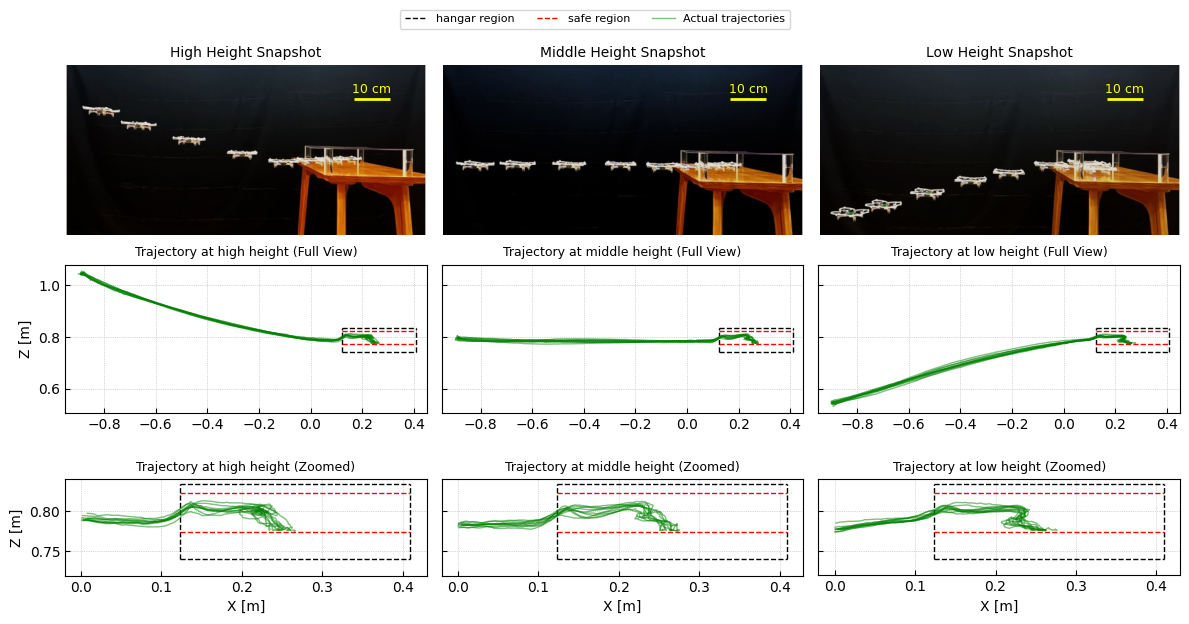

Plot saved to pdf_varying_height_plot.pdf


In [74]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse

import uav_trajectory
import pandas as pd
import glob

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories', linewidth= 1.0)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth= 1.0)


# --- New/Modified Function for Scale Bar ---
def add_simple_scale_bar(ax: plt.Axes, length_label: str = "10 cm", color: str = 'white', line_width: int = 2,
                         x_pos_frac: float = 0.05, y_pos_frac: float = 0.05,
                         length_frac: float = 0.081, font_size: int = 8):
    """
    Adds a simple scale bar and text label to the bottom-left of an Axes.
    This scale bar is positioned and sized relative to the Axes' dimensions,
    not tied to the image's inherent pixel-to-physical scale.

    Args:
        ax (plt.Axes): The axes to add the scale bar to.
        length_label (str): The text label for the scale bar (e.g., "10 cm").
        color (str): Color of the scale bar line and text.
        line_width (int): Thickness of the scale bar line.
        x_pos_frac (float): X-position of the left end of the scale bar, as a fraction of Axes width (0 to 1).
        y_pos_frac (float): Y-position of the bottom of the scale bar, as a fraction of Axes height (0 to 1).
        length_frac (float): Length of the scale bar, as a fraction of Axes width (0 to 1).
        font_size (int): Font size for the text label.
    """
    # Use ax.transAxes to position relative to the Axes itself
    ax.plot([x_pos_frac, x_pos_frac + length_frac],
            [y_pos_frac, y_pos_frac],
            color=color, linewidth=line_width, transform=ax.transAxes,
            solid_capstyle='butt')

    ax.text(x_pos_frac + length_frac / 2, y_pos_frac + 0.02, # 0.02 is a small offset above the bar
            length_label, color=color, fontsize=font_size,
            ha='center', va='bottom', transform=ax.transAxes)


if __name__ == '__main__':
    x_start = -0.90
    fig, axs = plt.subplots(3, 3, figsize=(12, 6), sharey='row')

    labels = ['high', 'middle', 'low']
    img_paths = [f'./data/imgs/{lbl}_snapshot.jpg' for lbl in labels]
    data_paths = [f'./data/varying_height/{lbl}/*.csv' for lbl in labels]

    for j in range(3):  # Each column represents a height category
        label = labels[j]
        img_path = img_paths[j]
        act_traj_path = data_paths[j]

        # Row 0: Image snapshot
        img = plt.imread(img_path)
        axs[0, j].imshow(img)
        axs[0, j].axis('off')
        axs[0, j].set_aspect('equal')  # 防止图像拉伸导致的尺寸变化
        # Call the simplified scale bar function
        # Adjusted length_frac (0.15 for 15% of subplot width) and color (white) for visibility
        add_simple_scale_bar(axs[0, j], length_label="10 cm", color='yellow',
                             x_pos_frac=0.8, y_pos_frac=0.8, length_frac=0.1, font_size=9)
        # Add titles for the top row (images)
        axs[0, j].set_title(f'{label.capitalize()} Height Snapshot', fontsize=10)


        # Row 1: Actual trajectory (full view)
        axs[1, j].set_xlim(-0.95, 0.45)
        # axs[1, j].set_ylim(0.5, 1.1)
        axs[1, j].set_aspect('equal')
        axs[1, j].grid(linestyle=':', linewidth=0.5)
        if j == 0: # Only set ylabel for the first subplot in the row
            axs[1, j].set_ylabel('Z [m]')
        # No xlabel for this row as the bottom row has it, and sharex=True is not set across rows
        axs[1, j].set_title(f'Trajectory at {label} height (Full View)', fontsize=9) # Add specific title for each subplot
        plot_hangar_box(axs[1, j])
        plot_safe_barrier(axs[1, j])
        plot_actual_trajectory(axs[1, j], act_traj_path, x_start)


        # Row 2: Improved trajectory (zoomed view)
        # axs[2, j].set_xlim(-0.1, 0.45) # Adjust x-lim for zoomed view if needed based on `x_start=0.0`
        axs[2, j].set_ylim(0.72, 0.84)
        axs[2, j].set_aspect('equal')
        axs[2, j].grid(linestyle=':', linewidth=0.5)
        if j == 0: # Only set ylabel for the first subplot in the row
            axs[2, j].set_ylabel('Z [m]')
        axs[2, j].set_xlabel("X [m]") # Set xlabel for all subplots in the bottom row
        axs[2, j].set_title(f'Trajectory at {label} height (Zoomed)', fontsize=9) # Add specific title
        plot_hangar_box(axs[2, j])
        plot_safe_barrier(axs[2, j])
        plot_actual_trajectory(axs[2, j], act_traj_path, x_start=0.0)  # No translation


    # Collect legend handles and labels from relevant subplots (Row 1 is good)
    handles, labels = [], []
    for ax in axs[1]:  # Collect from the first trajectory row
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    for i in range(3):
        for j in range(3):
            axs[i][j].tick_params(axis='both', direction='in')

    # Add global legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=8)

    # plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for the legend and potentially x-axis labels
    # plt.subplots_adjust(hspace=0.3, wspace=0.1) # Adjusted hspace to accommodate titles better

    plt.tight_layout()
    # Save as PDF
    output_file = 'pdf_varying_height_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")

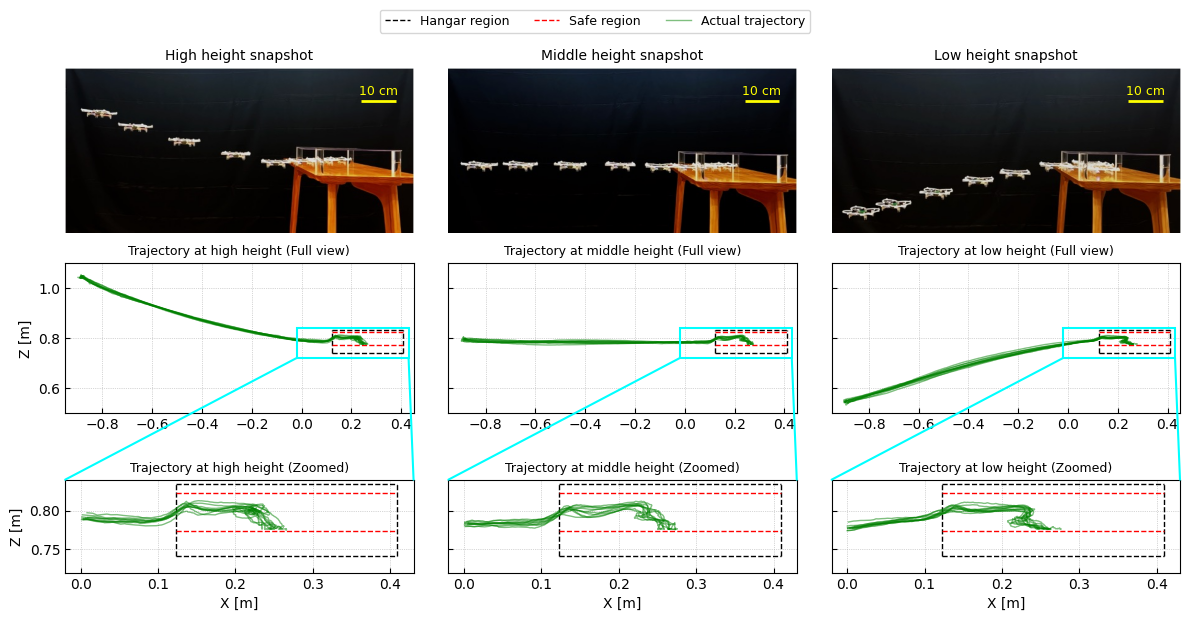

Plot saved to pdf_varying_height_plot.pdf


In [112]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse
from matplotlib.patches import Rectangle, ConnectionPatch # Import necessary patches

import uav_trajectory
import pandas as pd
import glob

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectory', linewidth= 1.0)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth= 1.0)


# --- Scale Bar Function ---
def add_simple_scale_bar(ax: plt.Axes, length_label: str = "10 cm", color: str = 'white', line_width: int = 2,
                         x_pos_frac: float = 0.05, y_pos_frac: float = 0.05,
                         length_frac: float = 0.081, font_size: int = 8):
    """
    Adds a simple scale bar and text label to the bottom-left of an Axes.
    This scale bar is positioned and sized relative to the Axes' dimensions,
    not tied to the image's inherent pixel-to-physical scale.

    Args:
        ax (plt.Axes): The axes to add the scale bar to.
        length_label (str): The text label for the scale bar (e.g., "10 cm").
        color (str): Color of the scale bar line and text.
        line_width (int): Thickness of the scale bar line.
        x_pos_frac (float): X-position of the left end of the scale bar, as a fraction of Axes width (0 to 1).
        y_pos_frac (float): Y-position of the bottom of the scale bar, as a fraction of Axes height (0 to 1).
        length_frac (float): Length of the scale bar, as a fraction of Axes width (0 to 1).
        font_size (int): Font size for the text label.
    """
    ax.plot([x_pos_frac, x_pos_frac + length_frac],
            [y_pos_frac, y_pos_frac],
            color=color, linewidth=line_width, transform=ax.transAxes,
            solid_capstyle='butt')

    ax.text(x_pos_frac + length_frac / 2, y_pos_frac + 0.02,
            length_label, color=color, fontsize=font_size,
            ha='center', va='bottom', transform=ax.transAxes)


if __name__ == '__main__':
    x_start = -0.90
    fig, axs = plt.subplots(3, 3, figsize=(12, 6), sharey='row') # sharey='row' is important for consistent Z-axis ranges within rows

    labels = ['high', 'middle', 'low']
    img_paths = [f'./data/imgs/{lbl}_snapshot.jpg' for lbl in labels]
    data_paths = [f'./data/varying_height/{lbl}/*.csv' for lbl in labels]

    for j in range(3):  # Each column represents a height category
        label = labels[j]
        img_path = img_paths[j]
        act_traj_path = data_paths[j]

        # Row 0: Image snapshot
        axs[0, j].imshow(plt.imread(img_path))
        axs[0, j].axis('off')
        axs[0, j].set_aspect('equal')
        add_simple_scale_bar(axs[0, j], length_label="10 cm", color='yellow',
                             x_pos_frac=0.85, y_pos_frac=0.8, length_frac=0.1, font_size=9)
        axs[0, j].set_title(f'{label.capitalize()} height snapshot', fontsize=10)


        # Row 1: Actual trajectory (full view)
        ax_full = axs[1, j] # Rename for clarity
        ax_full.set_xlim(-0.95, 0.45)
        ax_full.set_ylim(0.5, 1.1) # Retained explicit ylim
        ax_full.set_aspect('equal')
        ax_full.grid(linestyle=':', linewidth=0.5)
        if j == 0:
            ax_full.set_ylabel('Z [m]')
        ax_full.set_title(f'Trajectory at {label} height (Full view)', fontsize=9)
        plot_hangar_box(ax_full)
        plot_safe_barrier(ax_full)
        plot_actual_trajectory(ax_full, act_traj_path, x_start)


        # Row 2: Improved trajectory (zoomed view)
        ax_zoom = axs[2, j] # Rename for clarity
        zoom_xlim = [-0.02, 0.43] # Define these for consistency
        zoom_ylim = [0.72, 0.84] # Define these for consistency
        ax_zoom.set_xlim(zoom_xlim)
        ax_zoom.set_ylim(zoom_ylim)
        ax_zoom.set_aspect('equal')
        ax_zoom.grid(linestyle=':', linewidth=0.5)
        if j == 0:
            ax_zoom.set_ylabel('Z [m]')
        ax_zoom.set_xlabel("X [m]")
        ax_zoom.set_title(f'Trajectory at {label} height (Zoomed)', fontsize=9)
        plot_hangar_box(ax_zoom)
        plot_safe_barrier(ax_zoom)
        plot_actual_trajectory(ax_zoom, act_traj_path, x_start=0.0)

        # --- Add Zoom-in Annotation (Rectangle and Connection Lines) ---
        # Define the corners of the zoomed region in data coordinates for ax_full
        x1, x2 = zoom_xlim
        y1, y2 = zoom_ylim

        # Add a rectangle to ax_full
        rect = Rectangle((x1, y1), x2-x1, y2-y1,
                         facecolor='none', edgecolor='cyan', linewidth=1.5, linestyle='-', zorder=3)
        ax_full.add_patch(rect)

# From bottom-left of rect to top-left of ax_zoom
        con1 = ConnectionPatch(xyA=(x1, y1), xyB=(0, 1),
                               coordsA="data", coordsB="axes fraction",
                               axesA=ax_full, axesB=ax_zoom,
                               color="cyan", linestyle='-', linewidth=1.5,
                               zorder=3)
        fig.add_artist(con1)

        # From bottom-right of rect to top-right of ax_zoom
        con2 = ConnectionPatch(xyA=(x2, y1), xyB=(1, 1),
                               coordsA="data", coordsB="axes fraction",
                               axesA=ax_full, axesB=ax_zoom,
                               color="cyan", linestyle='-', linewidth=1.5,
                               zorder=3)
        fig.add_artist(con2)


    # Collect legend handles and labels
    handles, labels = [], []
    for ax in axs[1]:
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    for i in range(3):
        for j in range(3):
            axs[i][j].tick_params(axis='both', direction='in')

    # Add global legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=9)

    plt.tight_layout() # Call tight_layout first
    # Adjust subplots spacing
    plt.subplots_adjust(
        # left=0.05,    # Adjust left margin
        # right=0.98,   # Adjust right margin
        # top=0.94,     # Adjust top margin (to make space for legend and top row titles)
        # bottom=0.00,  # Adjust bottom margin (to make space for x-labels)
        wspace=0.1,   # Horizontal space between columns
        hspace=0.1    # Vertical space between rows - TUNE THIS VALUE
    )

    # Save as PDF
    output_file = 'pdf_varying_height_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")

# Varying Speed

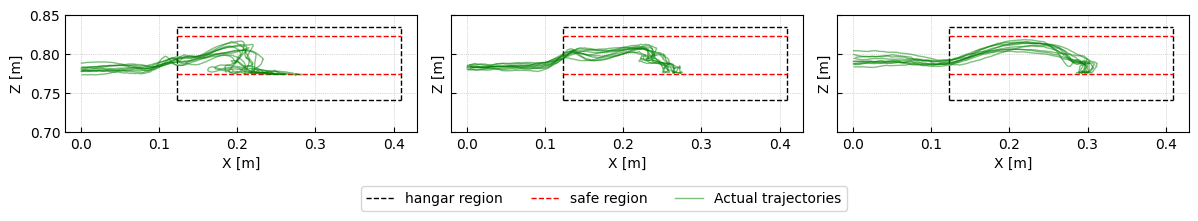

Plot saved to pdf_varying_speed_plot.pdf


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories', linewidth= 1)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth= 1)


if __name__ == '__main__':
    x_start = -0.90
    fig, axs = plt.subplots(1, 3, figsize=(12, 2), sharey='row')

    labels = ['0_25', '0_5', '1_0']
    data_paths = [f'./data/varying_speed/{lbl}/*.csv' for lbl in labels]

    for j in range(3):  # 每列一个高度类别
        label = labels[j]
        img_path = img_paths[j]
        act_traj_path = data_paths[j]

        # axs[0, j].set_xlim(-.95, 0.45)
        # axs[0, j].set_ylim(0.5, 1.1)
        # # axs[0, j].set_xticks(np.arange(-1.0, 0.6, 0.5))
        # # axs[0, j].set_yticks(np.arange(0.5, 1.1, 0.25))
        # axs[0, j].set_aspect('equal')
        # axs[0, j].grid(linestyle=':', linewidth=0.5)
        # axs[0, j].set_xlabel('x')
        # axs[0, j].set_ylabel('z')
        # plot_hangar_box(axs[0, j])
        # plot_safe_barrier(axs[0, j])
        # plot_actual_trajectory(axs[0, j], act_traj_path, x_start)

        # # Row 2: 改进后的轨迹
        # # axs[2, j].set_xlim(-1.0, 0.5)
        # axs[1, j].set_ylim(0.7, 0.85)
        # axs[1, j].set_aspect('equal')
        # axs[1, j].grid(linestyle=':', linewidth=0.5)
        # axs[1, j].set_ylabel('Z [m]')
        # plot_hangar_box(axs[1, j])
        # plot_safe_barrier(axs[1, j])
        # plot_actual_trajectory(axs[1, j], act_traj_path, x_start=0.0)  # 不平移
        # axs[1, j].set_xlabel("X [m]")  # 可选加上

        # Row 2: 改进后的轨迹
        # axs[2, j].set_xlim(-1.0, 0.5)
        axs[j].set_ylim(0.7, 0.85)
        axs[j].set_aspect('equal')
        axs[j].grid(linestyle=':', linewidth=0.5)
        axs[j].set_ylabel('Z [m]')
        plot_hangar_box(axs[j])
        plot_safe_barrier(axs[j])
        plot_actual_trajectory(axs[j], act_traj_path, x_start=0.0)  # 不平移
        axs[j].set_xlabel("X [m]")  # 可选加上


        # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs:  # 只遍历每个子图 axs[0]
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    for ax in axs:
        ax.tick_params(axis='both', direction='in')

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=3)

    plt.tight_layout()
    # Save as PDF
    output_file = 'pdf_varying_speed_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {output_file}")


## Vertical

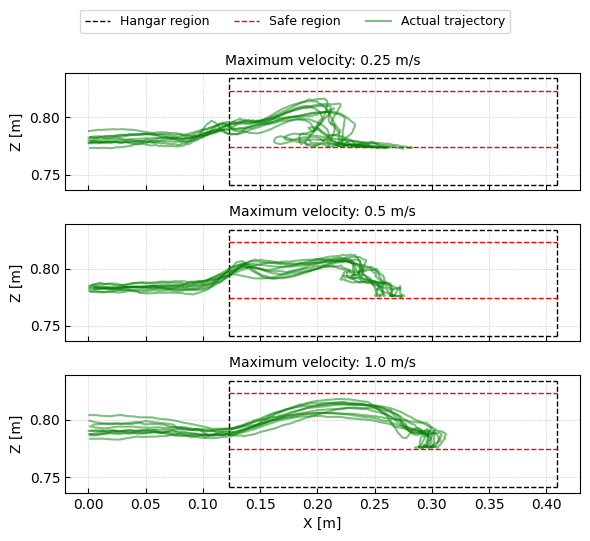

Plot saved to pdf_varying_speed_plot.pdf


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectory', linewidth= 1.5)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth= 1.5)


if __name__ == '__main__':
    x_start = -0.90
    # Changed to 3 rows, 1 column, and adjusted figsize
    fig, axs = plt.subplots(3, 1, figsize=(6, 5.5), sharex=True, sharey=True) # sharex=True ensures x-axes are linked

    labels = ['0_25', '0_5', '1_0']
    data_paths = [f'./data/varying_speed/{lbl}/*.csv' for lbl in labels]
    # Removed img_paths as it wasn't used

    for j in range(3):  # Loop through each row (now each subplot)
        label = labels[j]
        # img_path = img_paths[j] # Removed
        act_traj_path = data_paths[j]

        ax = axs[j] # Directly access the subplot for the current row

        # ax.set_ylim(0.7, 0.85)
        ax.set_aspect('equal')
        ax.grid(linestyle=':', linewidth=0.5)
        ax.set_ylabel('Z [m]')
        ax.set_title(f'Maximum velocity: {label.replace("_", ".")} m/s', fontsize=10) # Added subplot titles

        plot_hangar_box(ax)
        plot_safe_barrier(ax)
        plot_actual_trajectory(ax, act_traj_path, x_start=0.0)

        if j == 2: # Only set xlabel for the bottom-most subplot
            ax.set_xlabel("X [m]")

    # Collect legend handles and labels from all subplots
    handles, labels = [], []
    for ax in axs:
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    for ax in axs:
        ax.tick_params(axis='both', direction='in')

    # Add global legend, adjusted bbox_to_anchor for vertical layout
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fontsize=8)

    # # Adjust layout to prevent overlap and optimize spacing
    # plt.subplots_adjust(hspace=0.0) # Reduce vertical space between subplots
    # plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for the legend at the top

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fontsize=9)

    for i in range(3): # Loop through 3 subplots
        axs[i].tick_params(axis='both', direction='in')


    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for the legend
    plt.subplots_adjust(hspace=0.0) # Reduce horizontal space between subplots

    # Save as PDF
    output_file = 'pdf_varying_speed_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {output_file}")

# Ablation and Comparison

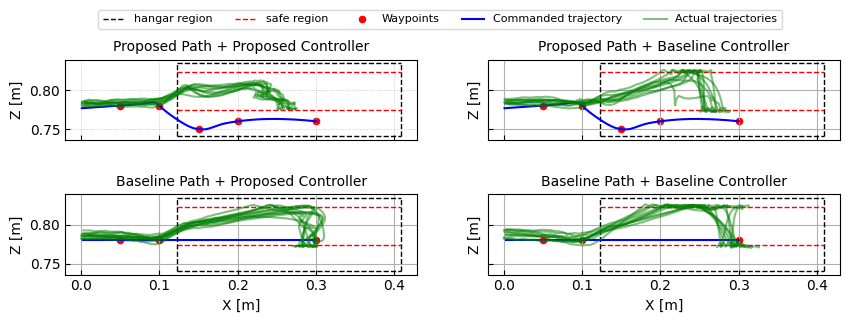

Plot saved to pdf_ablation.pdf


In [33]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse

import uav_trajectory
import pandas as pd
import glob

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    '''
    Load and filter the trajectory data from a CSV file with a title 't,x,y,z,qx,qy,qz,qw'.
    Args:
        file_path (str): Path to the CSV file containing trajectory data.
    Returns:
        pd.DataFrame: Filtered trajectory data excluding the last row and with x > -0.877.
    '''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], label="Commanded trajectory", color="blue", linewidth=1.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories', linewidth=1.5)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_', linewidth=1.5)

if __name__ == "__main__":

    x_start = - 0.0  # Default: -0.877 Value threshold for filtering the trajectory data
    fig, axs = plt.subplots(2, 2, figsize=(10, 3.5), sharex=True, sharey=True)

    # ============================
    # Subplot 0 0 , Proposed Path + Proposed Controller
    # ============================

    plot_hangar_box(axs[0,0])
    plot_safe_barrier(axs[0,0])

    # Plot waypoints
    waypoints_path = "../data/waypoints/final_middle.csv"
    plot_waypoints(axs[0,0], waypoints_path, x_start)

    # Plot commanded trajectory
    cmd_traj_path = "../data/trajectories/final_middle_traj.csv"
    plot_polynomial_trajectory(axs[0,0], cmd_traj_path, x_start)


    # Plot actual trajectory   
    act_traj_path = './data/ablation/PPPC/*.csv'
    plot_actual_trajectory(axs[0,0], act_traj_path, x_start)


    # axs[0,0].set_xlabel("X [m]")
    axs[0,0].set_ylabel("Z [m]")
    axs[0,0].set_title("Proposed Path + Proposed Controller", fontsize=10)
    axs[0,0].grid(linestyle=':', linewidth=0.5)
    axs[0,0].set_aspect('equal')


    # ============================
    # Subplot 1 0, Baseline Path + Proposed Controller
    # ============================

    plot_hangar_box(axs[1,0])
    plot_safe_barrier(axs[1,0])

    # Plot waypoints
    waypoints = np.array([
        [-0.893, 0.066, 0.780],
        [ 0.050, 0.066, 0.780],
        [ 0.100, 0.066, 0.780],
        [ 0.300, 0.066, 0.780]
    ])
    mask = waypoints[:, 0] > x_start
    axs[1,0].scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")

    # Plot commanded trajectory
    trajectory_path = "./data/ablation_1/middle_traj_plaint.csv"
    plot_polynomial_trajectory(axs[1,0], trajectory_path, x_start)

    # Plot real trajectory
    act_traj_path = './data/ablation/BPPC/*.csv'
    plot_actual_trajectory(axs[1,0], act_traj_path, x_start)

    axs[1,0].set_xlabel("X [m]")
    axs[1,0].set_ylabel("Z [m]")
    axs[1,0].set_title("Baseline Path + Proposed Controller", fontsize=10)
    axs[1,0].grid(True)
    axs[1,0].set_aspect("equal")


    # ============================
    # Subplot 0 1, Proposed Path + Baseline Controller
    # ============================

    plot_hangar_box(axs[0,1])
    plot_safe_barrier(axs[0,1])

    # Plot waypoints
    waypoints_path = "../data/waypoints/final_middle.csv"
    plot_waypoints(axs[0,1], waypoints_path, x_start)


    # Plot commanded trajectory
    cmd_traj_path = "../data/trajectories/final_middle_traj.csv"
    plot_polynomial_trajectory(axs[0,1], cmd_traj_path, x_start)

    # Plot real trajectory 
    act_traj_path = './data/ablation/PPBC/*.csv'
    plot_actual_trajectory(axs[0,1], act_traj_path, x_start)  

    # axs[0,1].set_xlabel("X [m]")
    axs[0,1].set_ylabel("Z [m]")
    axs[0,1].set_title("Proposed Path + Baseline Controller", fontsize=10)
    axs[0,1].grid(True)
    axs[0,1].set_aspect('equal')


    # ============================
    # Subplot 1 1, Baseline Path + Baseline Controller
    # ============================

    plot_hangar_box(axs[1,1])
    plot_safe_barrier(axs[1,1])

    # Plot waypoints
    waypoints = np.array([
        [-0.893, 0.066, 0.780],
        [ 0.050, 0.066, 0.780],
        [ 0.100, 0.066, 0.780],
        [ 0.300, 0.066, 0.780]
    ])
    mask = waypoints[:, 0] > x_start
    axs[1,1].scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")

    # Plot commanded trajectory
    cmd_traj_path = "./data/ablation_1/middle_traj_plaint.csv"
    plot_polynomial_trajectory(axs[1,1], cmd_traj_path, x_start)

    # Plot real trajectory
    act_traj_path = './data/ablation/BPBC/*.csv'
    plot_actual_trajectory(axs[1,1], act_traj_path, x_start)

    axs[1,1].set_xlabel("X [m]")
    axs[1,1].set_ylabel("Z [m]")
    axs[1,1].set_title("Baseline Path + Baseline Controller", fontsize=10)
    axs[1,1].grid(True)
    axs[1,1].set_aspect("equal")
   


    # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs[0]:  # 只遍历第一行的每个子图
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=5, fontsize=8)

    for i in range(2):
        for j in range(2):
            axs[i][j].tick_params(axis='both', direction='in')


    # plt.tight_layout(h_pad=0.2)
    plt.subplots_adjust(hspace=0.0)

    # plt.show()

    output_file = 'pdf_ablation.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")


    # import matplotlib.pyplot as plt
    # print(plt.rcParams['lines.linewidth'])  # 输出: 1.5

    # print("线条相关配置参数：")
    # for key in plt.rcParams:
    #     if key.startswith('lines.'):
    #         print(f"{key}: {plt.rcParams[key]}")
    # import matplotlib
    # print(matplotlib.__version__)

## Vertical

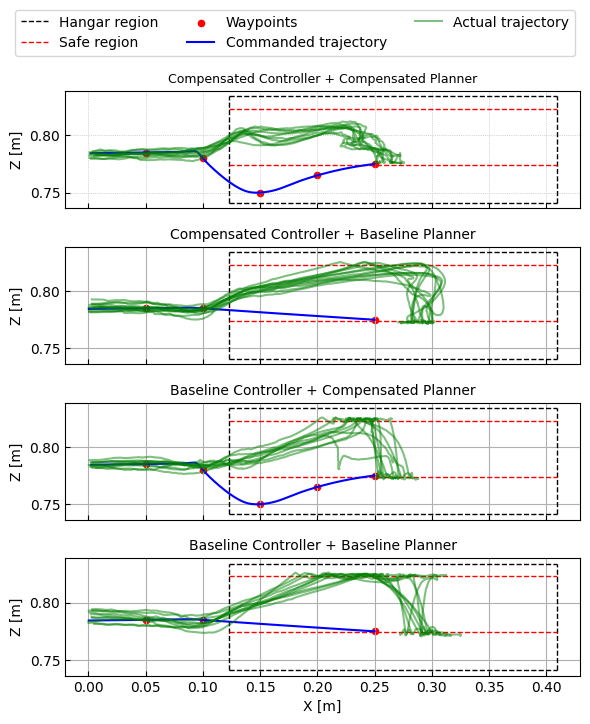

Plot saved to pdf_ablation.pdf


In [111]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse

import uav_trajectory
import pandas as pd
import glob

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    '''
    Load and filter the trajectory data from a CSV file with a title 't,x,y,z,qx,qy,qz,qw'.
    Args:
        file_path (str): Path to the CSV file containing trajectory data.
    Returns:
        pd.DataFrame: Filtered trajectory data excluding the last row and with x > -0.877.
    '''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], label="Commanded trajectory", color="blue", linewidth=1.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectory',linewidth=1.5)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth=1.5)

if __name__ == "__main__":

    x_start = - 0.0  # Default: -0.877 Value threshold for filtering the trajectory data
    
    # Change subplots to 4 rows, 1 column
    fig, axs = plt.subplots(4, 1, figsize=(6, 7.3), sharex=True, sharey=True) # Adjust figsize as needed

    # ============================
    # Subplot 0, Full Compensation (FC)
    # ============================

    plot_hangar_box(axs[0])
    plot_safe_barrier(axs[0])

    # Plot waypoints
    waypoints_path = "./data/ablation/waypoints/final_middle.csv"
    plot_waypoints(axs[0], waypoints_path, x_start)

    # Plot commanded trajectory
    cmd_traj_path = "./data/ablation/trajectories/final_middle_traj.csv"
    plot_polynomial_trajectory(axs[0], cmd_traj_path, x_start)

    # Plot actual trajectory   
    act_traj_path = './data/ablation/PPPC/*.csv'
    plot_actual_trajectory(axs[0], act_traj_path, x_start)

    axs[0].set_ylabel("Z [m]")
    # Updated Title for FC
    axs[0].set_title("Compensated Controller + Compensated Planner", fontsize=9)
    axs[0].grid(linestyle=':', linewidth=0.5)
    axs[0].set_aspect('equal')


    # ============================
    # Subplot 1, Controller Compensation Only (CCO)
    # Note: Your initial code for Subplot 1 was "Baseline Path + Proposed Controller".
    # Based on your new descriptions, "Controller Compensation Only (CCO)" is 
    # "Baseline Planner + Compensated Controller". This will affect which data/paths
    # you might need to load if they differ from the original "BPPC" path.
    # For now, I'm keeping your existing data paths for BPPC but updating the title.
    # If CCO uses different data, you'll need to change act_traj_path and trajectory_path.
    # ============================

    plot_hangar_box(axs[1])
    plot_safe_barrier(axs[1])

    # # Plot waypoints
    # waypoints = np.array([
    #     [-0.893, 0.066, 0.780],
    #     [ 0.050, 0.066, 0.780],
    #     [ 0.100, 0.066, 0.780],
    #     [ 0.300, 0.066, 0.780]
    # ])
    # mask = waypoints[:, 0] > x_start
    # axs[1].scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")

    # Plot waypoints
    waypoints_path = "./data/ablation/waypoints/baseline.csv"
    plot_waypoints(axs[1], waypoints_path, x_start)

    # Plot commanded trajectory
    trajectory_path = "./data/ablation/trajectories/baseline_traj.csv"
    plot_polynomial_trajectory(axs[1], trajectory_path, x_start)

    # Plot real trajectory
    act_traj_path = './data/ablation/BPPC/*.csv' # Currently uses BPPC data
    plot_actual_trajectory(axs[1], act_traj_path, x_start)

    axs[1].set_ylabel("Z [m]")
    # Updated Title for CCO
    axs[1].set_title("Compensated Controller + Baseline Planner", fontsize=10)
    axs[1].grid(True)
    axs[1].set_aspect("equal")


    # ============================
    # Subplot 2, Planner Compensation Only (PCO)
    # Note: Your initial code for Subplot 2 was "Proposed Path + Baseline Controller".
    # Based on your new descriptions, "Planner Compensation Only (PCO)" is 
    # "Compensated Planner + Baseline Controller". This will affect which data/paths
    # you might need to load if they differ from the original "PPBC" path.
    # For now, I'm keeping your existing data paths for PPBC but updating the title.
    # If PCO uses different data, you'll need to change act_traj_path and trajectory_path.
    # ============================

    plot_hangar_box(axs[2])
    plot_safe_barrier(axs[2])

    # Plot waypoints
    waypoints_path = "./data/ablation/waypoints/final_middle.csv"
    plot_waypoints(axs[2], waypoints_path, x_start)

    # Plot commanded trajectory
    cmd_traj_path = "./data/ablation/trajectories/final_middle_traj.csv"
    plot_polynomial_trajectory(axs[2], cmd_traj_path, x_start)

    # Plot real trajectory 
    act_traj_path = './data/ablation/PPBC/*.csv' # Currently uses PPBC data
    plot_actual_trajectory(axs[2], act_traj_path, x_start)  

    axs[2].set_ylabel("Z [m]")
    # Updated Title for PCO
    axs[2].set_title("Baseline Controller + Compensated Planner", fontsize=10)
    axs[2].grid(True)
    axs[2].set_aspect('equal')


    # ============================
    # Subplot 3, Baseline (BL)
    # ============================

    plot_hangar_box(axs[3])
    plot_safe_barrier(axs[3])

    # # Plot waypoints
    # waypoints = np.array([
    #     [-0.893, 0.066, 0.780],
    #     [ 0.050, 0.066, 0.780],
    #     [ 0.100, 0.066, 0.780],
    #     [ 0.300, 0.066, 0.780]
    # ])
    # mask = waypoints[:, 0] > x_start
    # axs[3].scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")

    # Plot waypoints
    waypoints_path = "./data/ablation/waypoints/baseline.csv"
    plot_waypoints(axs[3], waypoints_path, x_start)

    # Plot commanded trajectory
    cmd_traj_path = "./data/ablation/trajectories/baseline_traj.csv"
    plot_polynomial_trajectory(axs[3], cmd_traj_path, x_start)

    # Plot real trajectory
    act_traj_path = './data/ablation/BPBC/*.csv'
    plot_actual_trajectory(axs[3], act_traj_path, x_start)

    axs[3].set_xlabel("X [m]") # Set xlabel only for the very last subplot
    axs[3].set_ylabel("Z [m]")
    # Updated Title for BL
    axs[3].set_title("Baseline Controller + Baseline Planner", fontsize=10 )
    axs[3].grid(True)
    axs[3].set_aspect("equal")
   

    # Collect legend handles and labels from all subplots
    handles, labels = [], []
    for ax in axs: # Iterate through all subplots
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # Add global legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=3, fontsize=10)

    for i in range(4): # Loop through 4 subplots
        axs[i].tick_params(axis='both', direction='in')


    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for the legend
    plt.subplots_adjust(hspace=0.0) # Reduce horizontal space between subplots

    output_file = 'pdf_ablation.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")

# Step Disturbance Response

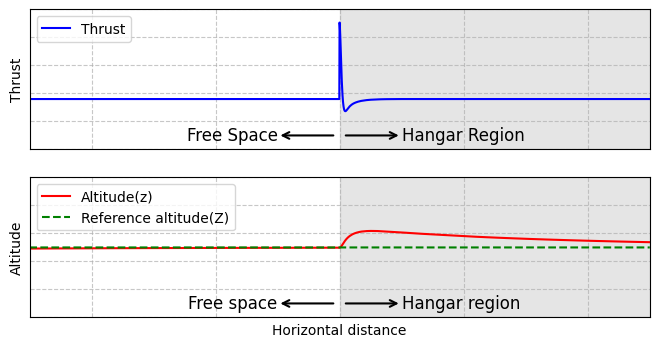

Plot saved to pdf_disturbance.pdf


In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load the data from the CSV file ---
# Replace 'z_pos.csv' with the actual path to your CSV file
try:
    df = pd.read_csv('z_pos.csv')
except FileNotFoundError:
    print("Error: 'z_pos.csv' not found. Please make sure the CSV file is in the same directory as the script or provide the full path.")
    exit()

# --- 2. Create the plot ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Define common properties for text (excluding ha and va)
# ha and va will be set explicitly in each annotate call
text_common_props = dict(fontsize=12, color='k')

# Define the x-axis limits and regions
plot_x_min, plot_x_max = 15, 25
hangar_start = 20
hangar_end = 25

# --- Subplot 1: Thrust ---
ax1.plot(df['t'], df['thrust'], label='Thrust', color='blue')
ax1.axvspan(hangar_start, hangar_end, color='gray', alpha=0.2, )
ax1.set_ylabel('Thrust')
ax1.set_ylim(16, 26)
ax1.set_xlim(plot_x_min, plot_x_max)
# ax1.set_title('Thrust over Time')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Calculate y position for the annotations relative to ax1's y-limits
annotation_y_ax1 = ax1.get_ylim()[0] + 0.1 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])

# Add annotations for ax1
# Free Space (Left Arrow pointing from the right)
ax1.annotate('Free Space',
             xy=(hangar_start - 0.1, annotation_y_ax1), # Arrow points to the boundary of hangar_start
             xytext=(hangar_start - 1, annotation_y_ax1), # Text position, slightly to the left of hangar_start
             arrowprops=dict(arrowstyle='<-', color='k', shrinkA=0, shrinkB=0, linewidth=1.5), # Arrow points left
             **text_common_props, # Apply common text properties
             ha='right', # Horizontal alignment for this specific text
             va='center' # Vertical alignment for this specific text
             )

# Hangar Region (Right Arrow pointing from the left)
ax1.annotate('Hangar Region',
             xy=(hangar_start + 0.1, annotation_y_ax1), # Arrow points to the boundary of hangar_end
             xytext=(hangar_start + 1, annotation_y_ax1), # Text position, slightly to the right of hangar_end
             arrowprops=dict(arrowstyle='<-', color='k', shrinkA=0, shrinkB=0, linewidth=1.5), # Arrow points right
             **text_common_props, # Apply common text properties
             ha='left', # Horizontal alignment for this specific text
             va='center' # Vertical alignment for this specific text
             )

# --- Subplot 2: Z and Z_ref ---
ax2.plot(df['t'], df['z'], label='Altitude(z)', color='red')
ax2.axvspan(hangar_start, hangar_end, color='gray', alpha=0.2)
ax2.plot(df['t'], df['z_ref'], label='Reference altitude(Z)', color='green', linestyle='--')
ax2.set_xlabel('Horizontal distance')
ax2.set_ylabel('Altitude')
ax2.set_ylim(0.5, 0.6)
ax2.set_xlim(plot_x_min, plot_x_max)
# ax2.set_title('Altitude (z) over Time')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='upper left')

# Calculate y position for the annotations relative to ax2's y-limits
annotation_y_ax2 = ax2.get_ylim()[0] + 0.1 * (ax2.get_ylim()[1] - ax2.get_ylim()[0])

# Add annotations for ax2
# Free Space (Left Arrow)
ax2.annotate('Free space',
             xy=(hangar_start - 0.1, annotation_y_ax2),
             xytext=(hangar_start - 1, annotation_y_ax2),
             arrowprops=dict(arrowstyle='<-', color='k', shrinkA=0, shrinkB=0, linewidth=1.5),
             **text_common_props,
             ha='right',
             va='center'
             )

# Hangar Region (Right Arrow)
ax2.annotate('Hangar region',
             xy=(hangar_start + 0.1, annotation_y_ax2),
             xytext=(hangar_start + 1, annotation_y_ax2),
             arrowprops=dict(arrowstyle='<-', color='k', shrinkA=0, shrinkB=0, linewidth=1.5),
             **text_common_props,
             ha='left',
             va='center'
             )

# --- Tick parameter adjustments ---
# Hide X-axis tick marks and labels
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Hide Y-axis tick marks and labels
ax1.tick_params(axis='y', which='both', left=False, labelleft=False) # Changed labelbottom to labelleft
ax2.tick_params(axis='y', which='both', left=False, labelleft=False) # Changed labelbottom to labelleft

# --- Adjust layout and display ---
output_file = 'pdf_disturbance.pdf'
dpi = 300
plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
plt.show()
plt.close()
print(f"Plot saved to {output_file}")

# Trajectory Compensation

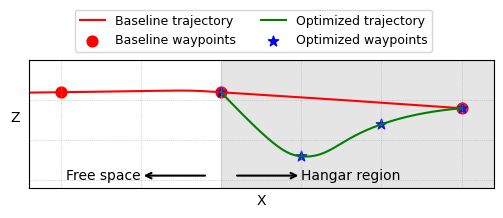

Plot saved to pdf_waypoints_trajectory.pdf


In [115]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse

import uav_trajectory
import pandas as pd
import glob


def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877, color_fun='red', alpha_fun = 0.5, marker_fun = 'o', size_fun = 20, label_fun = None):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], color =  color_fun, marker = marker_fun, s=size_fun, label=label_fun,alpha=alpha_fun)


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start= -0.877, color_fun= "blue",alpha_fun = 0.5, label_fun = None):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], label=label_fun, color=color_fun, linewidth=1.5,alpha=alpha_fun)

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.74+0.03, 0.83-0.01
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'Safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right


if __name__ == "__main__":

    x_start = - 0.1  # Default: -0.877 Value threshold for filtering the trajectory data
    fig, axs = plt.subplots(1, 1, figsize=(6, 2), sharex=True, sharey=True)

    # plot_hangar_box(axs)
    # plot_safe_barrier(axs)

    ## ============================ Baseline trajectory

    # Plot commanded trajectory
    cmd_traj_path = "./waypoints_trajectory/baseline_traj.csv"
    plot_polynomial_trajectory(axs, cmd_traj_path, x_start, color_fun = 'red', alpha_fun= 1.0, label_fun = 'Baseline trajectory')

    waypoints_path = "./waypoints_trajectory/baseline_waypoints.csv"
    plot_waypoints(axs, waypoints_path, x_start, color_fun = 'red',alpha_fun=1.0, size_fun=60, label_fun = 'Baseline waypoints')


    ## ============================ Optimized trajectory

    # Plot commanded trajectory
    cmd_traj_path = "./waypoints_trajectory/optimized_traj.csv"
    plot_polynomial_trajectory(axs, cmd_traj_path, x_start, color_fun= 'green', alpha_fun=1.0, label_fun = 'Optimized trajectory')
    
    # Plot waypoints
    waypoints_path = "./waypoints_trajectory/optimized_waypoints.csv"
    plot_waypoints(axs, waypoints_path, x_start, color_fun = 'blue',alpha_fun=1.0, marker_fun= '*',size_fun=60, label_fun = 'Optimized waypoints')



    axs.axvspan(0.1, 0.4, color='gray', alpha=0.2, )

    axs.set_xlim(-0.02,0.27)
    axs.set_ylim(0.72,0.8)
    axs.set_xlabel("X")
    axs.set_ylabel("Z",rotation = 'horizontal',loc ='center', labelpad=10)
    # axs.set_title("Baseline Trajectory vs Optimized Trajectory", fontsize=10)
    axs.grid(linestyle=':', linewidth=0.5)
    axs.set_aspect('equal')


    # Define common properties for text (excluding ha and va)
    # ha and va will be set explicitly in each annotate call
    text_common_props = dict(fontsize=10, color='k')

    # Calculate y position for the annotations relative to axs's y-limits
    annotation_y_axs = axs.get_ylim()[0] + 0.1 * (axs.get_ylim()[1] - axs.get_ylim()[0])
    hangar_start = 0.1

    # Add annotations for axs
    # Free Space (Left Arrow pointing from the right)
    axs.annotate('Free space',
                xy=(hangar_start - 0.01, annotation_y_axs), # Arrow points to the boundary of hangar_start
                xytext=(hangar_start - 0.05, annotation_y_axs), # Text position, slightly to the left of hangar_start
                arrowprops=dict(arrowstyle='<-', color='k', shrinkA=0, shrinkB=0, linewidth=1.5), # Arrow points left
                **text_common_props, # Apply common text properties
                ha='right', # Horizontal alignment for this specific text
                va='center' # Vertical alignment for this specific text
                )

    # Hangar Region (Right Arrow pointing from the left)
    axs.annotate('Hangar region',
                xy=(hangar_start + 0.01, annotation_y_axs), # Arrow points to the boundary of hangar_end
                xytext=(hangar_start + 0.05, annotation_y_axs), # Text position, slightly to the right of hangar_end
                arrowprops=dict(arrowstyle='<-', color='k', shrinkA=0, shrinkB=0, linewidth=1.5), # Arrow points right
                **text_common_props, # Apply common text properties
                ha='left', # Horizontal alignment for this specific text
                va='center' # Vertical alignment for this specific text
                )


    # ...existing code...
    handles, labels = [], []
    for h, l in zip(*axs.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
    # ...existing code...

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=9)


    # axs.tick_params(axis='both', direction='in')
    # Hide X-axis tick marks and labels
    axs.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # Hide Y-axis tick marks and labels
    axs.tick_params(axis='y', which='both', left=False, labelleft=False) # Changed labelbottom to labelleft

    # plt.tight_layout(h_pad=0.2)
    plt.subplots_adjust(hspace=0.0)

    # plt.show()

    output_file = 'pdf_waypoints_trajectory.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")

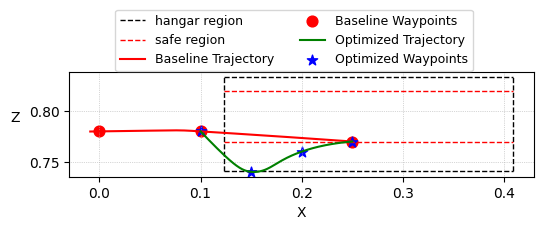

Plot saved to pdf_waypoints_trajectory.pdf


In [21]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse

import uav_trajectory
import pandas as pd
import glob


def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877, color_fun='red', alpha_fun = 0.5, marker_fun = 'o', size_fun = 20, label_fun = None):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], color =  color_fun, marker = marker_fun, s=size_fun, label=label_fun,alpha=alpha_fun)


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start= -0.877, color_fun= "blue",alpha_fun = 0.5, label_fun = None):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], label=label_fun, color=color_fun, linewidth=1.5,alpha=alpha_fun)

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.74+0.03, 0.83-0.01
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right


if __name__ == "__main__":

    x_start = - 0.01  # Default: -0.877 Value threshold for filtering the trajectory data
    fig, axs = plt.subplots(1, 1, figsize=(6, 2), sharex=True, sharey=True)

    plot_hangar_box(axs)
    plot_safe_barrier(axs)

    ## ============================ Baseline trajectory

    # Plot commanded trajectory
    cmd_traj_path = "./waypoints_trajectory/baseline_traj.csv"
    plot_polynomial_trajectory(axs, cmd_traj_path, x_start, color_fun = 'red', alpha_fun= 1.0, label_fun = 'Baseline Trajectory')

    waypoints_path = "./waypoints_trajectory/baseline_waypoints.csv"
    plot_waypoints(axs, waypoints_path, x_start, color_fun = 'red',alpha_fun=1.0, size_fun=60, label_fun = 'Baseline Waypoints')


    ## ============================ Optimized trajectory

    # Plot commanded trajectory
    cmd_traj_path = "./waypoints_trajectory/optimized_traj.csv"
    plot_polynomial_trajectory(axs, cmd_traj_path, x_start, color_fun= 'green', alpha_fun=1.0, label_fun = 'Optimized Trajectory')
    
    # Plot waypoints
    waypoints_path = "./waypoints_trajectory/optimized_waypoints.csv"
    plot_waypoints(axs, waypoints_path, x_start, color_fun = 'blue',alpha_fun=1.0, marker_fun= '*',size_fun=60, label_fun = 'Optimized Waypoints')


    # axs.set_xlim(-0.02,0.27)
    # axs.set_ylim(0.72,0.8)
    axs.set_xlabel("X")
    axs.set_ylabel("Z",rotation = 'horizontal',loc ='center', labelpad=10)
    # axs.set_title("Baseline Trajectory vs Optimized Trajectory", fontsize=10)
    axs.grid(linestyle=':', linewidth=0.5)
    axs.set_aspect('equal')


    # Define common properties for text (excluding ha and va)
    # ha and va will be set explicitly in each annotate call
    text_common_props = dict(fontsize=10, color='k')

    # Calculate y position for the annotations relative to axs's y-limits
    annotation_y_axs = axs.get_ylim()[0] + 0.1 * (axs.get_ylim()[1] - axs.get_ylim()[0])
    hangar_start = 0.1



    # ...existing code...
    handles, labels = [], []
    for h, l in zip(*axs.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
    # ...existing code...

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=9)


    # # axs.tick_params(axis='both', direction='in')
    # # Hide X-axis tick marks and labels
    # axs.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # # Hide Y-axis tick marks and labels
    # axs.tick_params(axis='y', which='both', left=False, labelleft=False) # Changed labelbottom to labelleft

    # plt.tight_layout(h_pad=0.2)
    plt.subplots_adjust(hspace=0.0)

    # plt.show()

    output_file = 'pdf_waypoints_trajectory.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")

## Two subplots

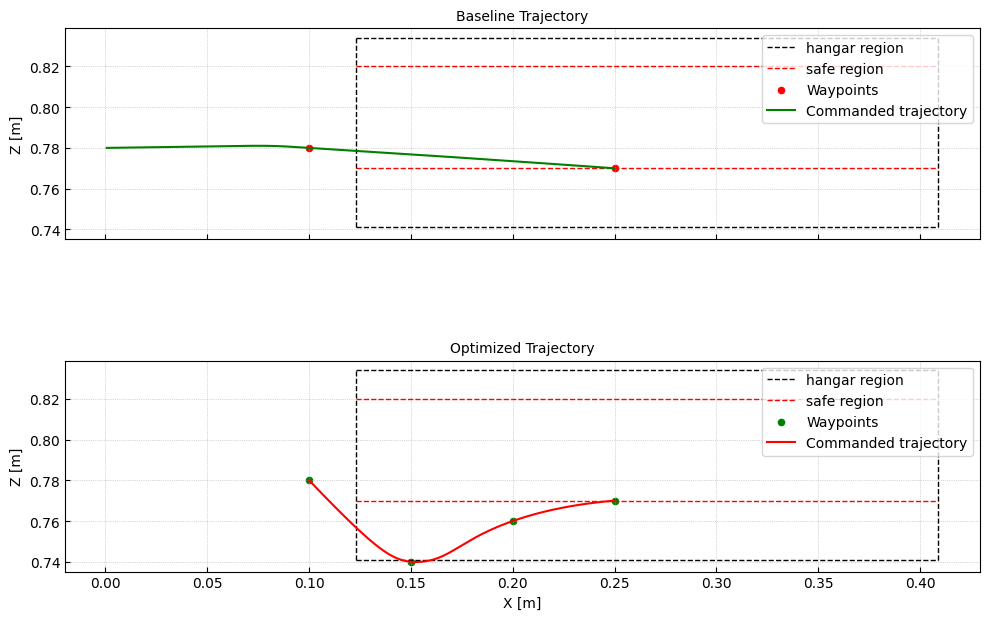

Plot saved to pdf_waypoints_trajectory_subplots.pdf


In [16]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Not used in this 2D plot, but kept if you need it later
import argparse # Not used in this script, but kept if you need it later

import uav_trajectory # Assuming this module is available
import pandas as pd # Not directly used for plotting here, but kept if you need it later
import glob # Not used in this script, but kept if you need it later


def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877, color_fun='red', alpha_fun = 0.5):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], color =  color_fun, marker="o", s=20, label="Waypoints",alpha=alpha_fun)


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start= -0.877, color_fun= "blue",alpha_fun = 0.5):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], label="Commanded trajectory", color=color_fun, linewidth=1.5,alpha=alpha_fun)


def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.74+0.03, 0.83-0.01
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right


if __name__ == "__main__":

    x_start = -0.00  # Default: -0.877 Value threshold for filtering the trajectory data

    # Create 2 subplots (2 rows, 1 column), sharing x and y axes for consistent scaling
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True) # Increased figsize for 2 subplots

    # # --- Plotting for ax1 (Baseline Trajectory) ---
    plot_hangar_box(ax1)
    plot_safe_barrier(ax1)

    # Baseline trajectory
    waypoints_path_baseline = "./waypoints_trajectory/baseline_waypoints.csv"
    plot_waypoints(ax1, waypoints_path_baseline, x_start, color_fun='red', alpha_fun=1.0)

    # Plot commanded trajectory
    cmd_traj_path_baseline = "./waypoints_trajectory/baseline_traj.csv"
    plot_polynomial_trajectory(ax1, cmd_traj_path_baseline, x_start, color_fun='green', alpha_fun=1.0)

    ax1.set_ylabel("Z [m]")
    ax1.set_title("Baseline Trajectory", fontsize=10) # Specific title for baseline
    ax1.grid(linestyle=':', linewidth=0.5)
    ax1.set_aspect('equal')
    ax1.tick_params(axis='both', direction='in')
    ax1.legend(loc='upper right') # Add legend to baseline subplot


    # --- Plotting for ax2 (Optimized Trajectory) ---
    plot_hangar_box(ax2)
    plot_safe_barrier(ax2)

    # Optimized trajectory
    waypoints_path_optimized = "./waypoints_trajectory/optimized_waypoints.csv"
    plot_waypoints(ax2, waypoints_path_optimized, x_start, color_fun='green', alpha_fun=1.0) # Changed color to differentiate from baseline waypoints

    # Plot commanded trajectory
    cmd_traj_path_optimized = "./waypoints_trajectory/optimized_traj.csv"
    plot_polynomial_trajectory(ax2, cmd_traj_path_optimized, x_start, color_fun='red', alpha_fun=1.0) # Changed color to differentiate from baseline trajectory

    ax2.set_xlabel("X [m]") # X-label only on the bottom subplot
    ax2.set_ylabel("Z [m]")
    ax2.set_title("Optimized Trajectory", fontsize=10) # Specific title for optimized
    ax2.grid(linestyle=':', linewidth=0.5)
    ax2.set_aspect('equal')
    ax2.tick_params(axis='both', direction='in')
    ax2.legend(loc='upper right') # Add legend to optimized subplot


    # Adjust layout to prevent overlap, especially between subplot titles and x-label
    plt.tight_layout(h_pad=0.2) # h_pad controls height between subplots
    plt.subplots_adjust(hspace=0.0) # Set hspace to 0.0 for minimal vertical spacing

    output_file = 'pdf_waypoints_trajectory_subplots.pdf' # New filename
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")